In [1]:
import pandas as pd
import numpy as np


X = pd.read_csv(r"C:\Users\fogat\ML challenges\titanic\train.csv")
X_copy = X.copy()
y = X.Survived
X_copy.drop(['Survived'], axis=1, inplace=True)
X_test = pd.read_csv(r"C:\Users\fogat\ML challenges\titanic\test.csv")

full = pd.concat([X, X_test], axis=0)

list(X.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Feature Engineering

In [2]:
full.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [3]:
import re

# Grab title from passenger names
def sep_title(name):
    pattern = r'(.*,)(.*[.])(.*)'
    test = re.compile(pattern)
    mo = test.search(name)
    return mo.group(2)

full['Title'] = full['Name'].apply(lambda x : sep_title(x))


full['Title'].value_counts()


Title
Mr.                          757
Miss.                        260
Mrs.                         196
Master.                       61
Rev.                           8
Dr.                            8
Col.                           4
Major.                         2
Ms.                            2
Mlle.                          2
Don.                           1
Mrs. Martin (Elizabeth L.      1
Mme.                           1
Sir.                           1
Lady.                          1
Capt.                          1
the Countess.                  1
Jonkheer.                      1
Dona.                          1
Name: count, dtype: int64

In [4]:
rare_title = ['Dona.', 'Lady.', 'the Countess.','Capt.', 'Col.', 'Don.', 
              'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.']

# Strip any whitespace and ensure case consistency
full['Title'] = full['Title'].str.strip()

# Apply the changes
full.loc[full['Title'].isin(rare_title), 'Title'] = 'rare title'
full.loc[full['Title'] == 'Mlle.', 'Title'] = 'Miss.'
full.loc[full['Title'] == 'Ms.', 'Title'] = 'Miss.'
full.loc[full['Title'] == 'Mme.', 'Title'] = 'Mrs.'
full.loc[full['Title'] == 'Mrs. Martin (Elizabeth L.', 'Title'] = 'Mrs.'

# Verify the changes
print("Unique titles after changes:", full['Title'].unique())
print("Title value counts:")
print(full['Title'].value_counts())


Unique titles after changes: ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'rare title']
Title value counts:
Title
Mr.           757
Miss.         264
Mrs.          198
Master.        61
rare title     29
Name: count, dtype: int64


In [5]:
def sep_family(name):
    if pd.isna(name):
        return None
    parts = name.split(',')
    return parts[0].strip() if parts else None

full['Family'] = full['Name'].apply(sep_family)
family_counts = full['Family'].value_counts()
# Replace single-member families with "Single"
full['Family'] = full['Family'].apply(lambda f: f if family_counts[f] > 1 else 'Single')

full['Family'].value_counts()

Family
Single       637
Andersson     11
Sage          11
Goodwin        8
Asplund        8
            ... 
Buckley        2
Mahon          2
Clark          2
Pokrnic        2
Gibson         2
Name: count, Length: 239, dtype: int64

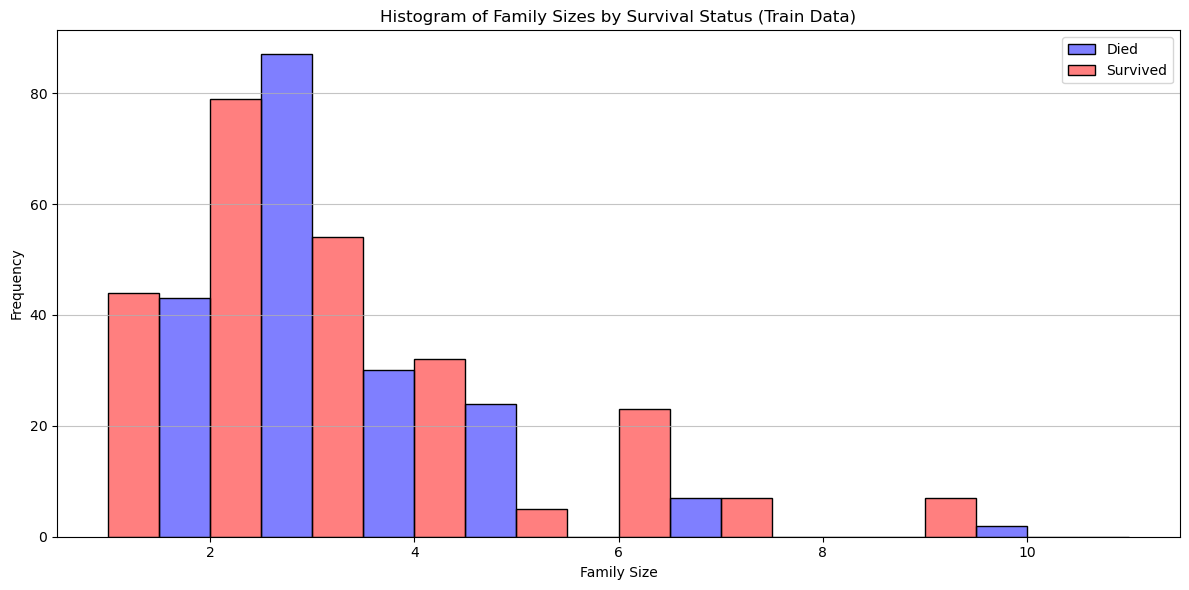

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate family size
X_plot = full[:890].copy()
family_size = X_plot.groupby('Family').size().reset_index(name='Size')

# Merge family size back to the dataframe
X_plot = X_plot.merge(family_size, on='Family', how='left')

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(
    data=X_plot,
    x='Size',
    hue='Survived',
    multiple='dodge',
    bins=range(1, 12),
    palette={0: 'red', 1: 'blue'},
    alpha=0.5,
    legend=True
)
# Labels and legend
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.title('Histogram of Family Sizes by Survival Status (Train Data)')
plt.legend(labels=['Died', 'Survived'])

# Show plot
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [7]:
from math import isnan

full['Deck'] = full['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'NaN')
full['Deck']

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
413    NaN
414      C
415    NaN
416    NaN
417    NaN
Name: Deck, Length: 1309, dtype: object

In [8]:
full['Embarked'].isna().sum()

np.int64(2)

Embarked nan are 61 and 829 and they both payed 80$ and 1st class

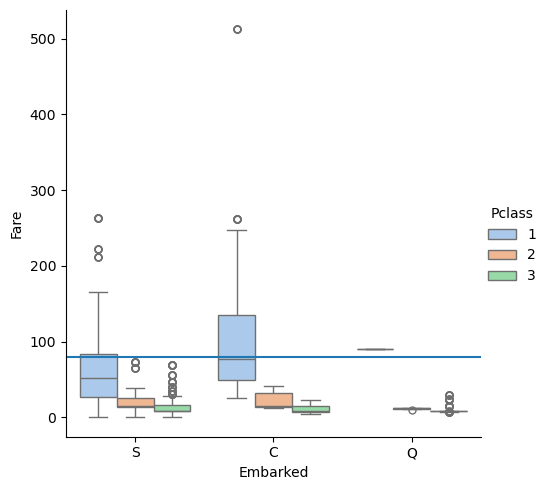

In [9]:
full = full.reset_index(drop=True)


sns.catplot(
    data = full,
    x = 'Embarked',
    y = 'Fare',
    hue = 'Pclass',
    kind = 'box',
    palette = 'pastel',
    legend = True
)

plt.axhline(y=80)

Assigning the value C seems a good approximation

In [10]:
full.loc[[61, 829],'Embarked'] = 'C'

In [11]:
full.Fare.median()

14.4542

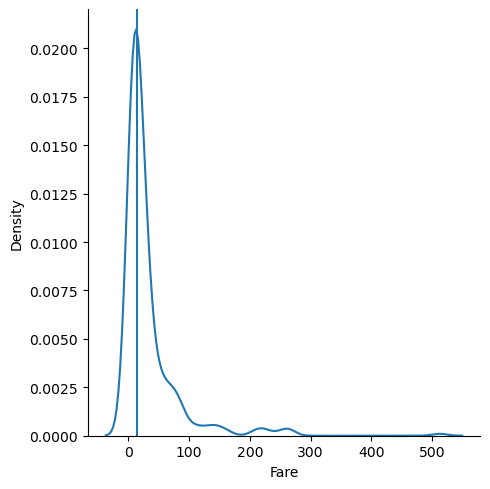

In [12]:
sns.displot(
    data = full,
    x = 'Fare',
    kind ='kde'
)

plt.axvline(x=full.Fare.median())

We will use the median for the only missing value in Fare

In [13]:
full.loc[1043,'Fare'] = full.Fare.median()

Pipeline engineering

In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, cross_val_score


class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        titles = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        titles = titles.replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
        return titles.to_frame(name='Title')


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd

class SafeIterativeImputer(BaseEstimator, TransformerMixin):
    """
    IterativeImputer that keeps original non-missing values intact.
    Works with both pandas DataFrames and NumPy arrays.
    Ensures same shape and index preservation.
    """
    def __init__(self, random_state=42, **kwargs):
        self.random_state = random_state
        self.kwargs = kwargs
        self.imputer = IterativeImputer(random_state=random_state, **kwargs)

    def fit(self, X, y=None):
        X_array = X if isinstance(X, np.ndarray) else X.values
        self.imputer.fit(X_array)
        return self

    def transform(self, X):
        X_array = X if isinstance(X, np.ndarray) else X.values
        X_imp_array = self.imputer.transform(X_array)

        if isinstance(X, pd.DataFrame):
            # Restore DataFrame with original shape
            X_imp = pd.DataFrame(X_imp_array, columns=X.columns, index=X.index)

            # Replace only missing values
            X_result = X.copy()
            for col in X.columns:
                mask = X[col].isna()
                X_result.loc[mask, col] = X_imp.loc[mask, col]

            # Guarantee same number of rows and index
            assert X_result.shape[0] == X.shape[0], "Imputer lost rows!"
            X_result.index = X.index

            return X_result

        # Otherwise, return NumPy array
        return X_imp_array


In [16]:
#Colmuns for imputation
num_features = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
cat_features = ['Sex', 'Embarked']
title_feature = ['Name']

# Encode Sex and Embarked as numeric
cat_transformer = OrdinalEncoder()

# Extract and one-hot encode Title
title_transformer = Pipeline(steps=[
    ('extract', TitleExtractor()),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine everything
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_features),
    ('cat', cat_transformer, cat_features),
    ('title', title_transformer, title_feature)
])

#use only on training data
X = full[:891].copy()


In [24]:
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SafeIterativeImputer()),
    ('model', RandomForestClassifier(random_state=42))
])

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
# Define parameter search space
param_distributions = {
    'model__n_estimators': randint(100,400),      # number of trees
    'model__max_depth': [None, 5, 10, 15],     # depth of each tree
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', 0.5],  # features per split
    'model__bootstrap': [True, False]
}

# Randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=30,                # number of random combinations to try
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # metric to optimize
    n_jobs=-1,                # use all CPU cores
    random_state=42,
    verbose=2
)

# Fit the search on your data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'model__bootstrap': False, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 7, 'model__n_estimators': 341}
Best CV Accuracy: 0.8441544371121836


In [26]:
best_pipeline = random_search.best_estimator_
print("Accuracy:", best_pipeline.score(X_valid, y_valid))
best_pipeline

Accuracy: 0.7932960893854749


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age', 'Pclass', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Sex', 'Embarked']),
                                                 ('title',
                                                  Pipeline(steps=[('extract',
                                                                   TitleExtractor()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name'])])),
                ('imputer', SafeIterativeImputer()),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=15,
                                        min_samples_leaf=4, min_samples_split=7,
                                        n_estimators=341, random_state=42))])

In [27]:
scores = cross_val_score(best_pipeline, X, y, cv=5)
print("Cross-validation mean accuracy:", scores.mean())

Cross-validation mean accuracy: 0.8238026489234824


In [28]:
best_pipeline.named_steps['model'].feature_importances_

array([0.11064468, 0.11369387, 0.05381711, 0.02028702, 0.13688363,
       0.18283596, 0.02439989, 0.        , 0.        , 0.        ,
       0.        , 0.00085842, 0.        , 0.        , 0.01413062,
       0.04628628, 0.22311283, 0.06778191, 0.0052678 ])

In [29]:
X_test.loc[1043-891,'Fare'] = full.Fare.median()
X_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SafeIterativeImputer()),
    ('model', GradientBoostingClassifier(random_state=42))
])

gb_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Age', 'Pclass', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Sex', 'Embarked']),
                                                 ('title',
                                                  Pipeline(steps=[('extract',
                                                                   TitleExtractor()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name'])])),
                ('imputer', SafeIterativeImputer()),
                ('model', GradientBoostingClassifier(random_state=42))])

In [48]:
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [2, 3, 4]
}

grid_search = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_gb = grid_search.best_estimator_

Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Best CV Score: 0.8441150398896878


In [49]:
model = best_gb.named_steps['model']

# Get feature names from the preprocessor
onehot_features = best_gb.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['encoder']\
    .get_feature_names_out(cat_features)

all_features = np.concatenate([num_features, onehot_features])

# Plot top 10 features
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8,6))
plt.barh(all_features[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.show()


AttributeError: 'OrdinalEncoder' object has no attribute 'named_steps'

In [50]:

X_test['Title'] = X_test['Name'].str.extract(r',\s*([^\.]*)\s*\.')
X_test['Title'] = X_test['Title'].replace(
    ['Mlle', 'Ms'], 'Miss').replace(
    ['Mme'], 'Mrs').replace(
    ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Sir', 'Capt', 'Lady', 'Jonkheer', 'Countess'], 'Rare'
)

predictions = best_gb.predict(X_test)
submission = pd.DataFrame({'PassengerId': X_test['PassengerId'], 'Survived': predictions})
submission.to_csv('submission.csv', index=False)
